# Clasificación de ingresos
Información obtenida del censo de estados unidos
## Objetivo
Determinar si una persona gana más de 50,000 USD al año

## Metodología:
* Vamos a hacerlo primero con un modelo de regresión logística
* Luego con un modelo de árbol de decisión

## Importando librerías

In [285]:
import pandas as pd
import numpy as np
import math

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["red", "w", "green"], N=256) #para entender más facil las correlaciones

import seaborn as sns
sns.set(style='whitegrid', context='notebook')

import warnings 
warnings.filterwarnings('ignore') # Lo utilzamos para ignorar los warnings que surgen por sugerencias de las librerías

## Obteniendo datos
Datos disponibles en: https://archive.ics.uci.edu/dataset/20/census+income

In [286]:
df_adult_data = pd.read_csv('adult.data', header=None)
columnas = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
df_adult_data.columns=columnas
df_adult_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [287]:
df_adult_test = pd.read_csv('adult.test', header=None, skiprows=1)
columnas = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
df_adult_test.columns=columnas
df_adult_test.income =df_adult_test.income.str.rstrip('.')
df_adult_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [288]:
print(df_adult_data.shape)
print(df_adult_test.shape)

(32561, 15)
(16281, 15)


## Análisis exporatorio de datos

In [289]:
df_adult_data.isna().sum()
#no hay valores nulos

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [290]:
df_adult_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


la columna *fnlwgt* no es relevante para el análisis, por lo que la eliminamos del dataset, pero es de utilidad para dar pesos a los datos en los modelos de clasificación.

In [291]:
df_fnlwgt = df_adult_data['fnlwgt']
#df_adult_data.drop('fnlwgt', axis=1, inplace=True)
df_fnlwgt

0         77516
1         83311
2        215646
3        234721
4        338409
          ...  
32556    257302
32557    154374
32558    151910
32559    201490
32560    287927
Name: fnlwgt, Length: 32561, dtype: int64

La columna *educational-num* es una versión numérica de la columna *education*, por lo que vamos a eliminar la columna *education* y crear un dataframe que contenga solo la columna *educational-num* y la columna *education* para decodificar después

In [292]:
df_educacion = df_adult_data.groupby(['education-num','education']).size().reset_index(name='counts')
# agrupamos por education-num y education y contamos cuantos hay de cada uno (es una serie con multiindex education num, education)
# reseteamos el indice (lo vuelve un dataframe) y le ponemos el nombre counts (a la unica columna que tenemos en la serie)
df_educacion

,education-num,education,counts
0,1,Preschool,51
1,2,1st-4th,168
2,3,5th-6th,333
3,4,7th-8th,646
4,5,9th,514
5,6,10th,933
6,7,11th,1175
7,8,12th,433
8,9,HS-grad,10501
9,10,Some-college,7291


Algo similar puede ocurrir con *marital-status* y *relationship*, por lo que veamos si tienen alguna agrupación similar y vemos que no aparentan tener una relación directa, por lo que las dejamos como están.

In [293]:
df_matrimonio = df_adult_data.groupby(['marital-status','relationship']).size().reset_index(name='counts')
df_matrimonio

,marital-status,relationship,counts
0,Divorced,Not-in-family,2404
1,Divorced,Other-relative,110
2,Divorced,Own-child,328
3,Divorced,Unmarried,1601
4,Married-AF-spouse,Husband,9
5,Married-AF-spouse,Other-relative,1
6,Married-AF-spouse,Own-child,1
7,Married-AF-spouse,Wife,12
8,Married-civ-spouse,Husband,13184
9,Married-civ-spouse,Not-in-family,17


In [294]:
df_adult_data.drop(["education"], axis=1, inplace=True)

In [295]:
df_adult_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Las columnas que contienen información que debemos convertir categorica son:	
* workclass
* marital-status
* ocupation
* relationship
* race
* sex
* native-country
* income


In [296]:
#Importante: todos nuestros tipos de datos son object, realizamos una transformacion
import category_encoders as ce #pip install category-encoders

encoder = ce.OrdinalEncoder(cols = ['workclass','marital-status','occupation','relationship','race','sex','native-country','income'])
df_adult_data = encoder.fit_transform(df_adult_data)

#para decodificar solamente hay que utilizar el metodo inverse_transform: encoder.inverse_transform(df_adult_data)
df_adult_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,1,77516,13,1,1,1,1,1,2174,0,40,1,1
1,50,2,83311,13,2,2,2,1,1,0,0,13,1,1
2,38,3,215646,9,3,3,1,1,1,0,0,40,1,1
3,53,3,234721,7,2,3,2,2,1,0,0,40,1,1
4,28,3,338409,13,2,4,3,2,2,0,0,40,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,257302,12,2,11,3,1,2,0,0,38,1,1
32557,40,3,154374,9,2,10,2,1,1,0,0,40,1,2
32558,58,3,151910,9,7,1,5,1,2,0,0,40,1,1
32559,22,3,201490,9,1,1,4,1,1,0,0,20,1,1


In [297]:
df_adult_test = df_adult_test[df_adult_data.columns]
df_adult_test = encoder.transform(df_adult_test)
df_adult_test

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,7,1,10,4,2,1,0,0,40,1,1
1,38,3,89814,9,2,9,2,1,1,0,0,50,1,1
2,28,5,336951,12,2,13,2,1,1,0,0,40,1,2
3,44,3,160323,10,2,10,2,2,1,7688,0,40,1,2
4,18,6,103497,10,1,12,4,1,2,0,0,30,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,3,215419,13,3,4,1,1,2,0,0,36,1,1
16277,64,6,321403,9,7,12,6,2,1,0,0,40,1,1
16278,38,3,374983,13,2,4,2,1,1,0,0,50,1,1
16279,44,3,83891,13,3,1,4,3,1,5455,0,40,1,1


In [298]:
df_adult_data.dtypes

age               int64
workclass         int32
fnlwgt            int64
education-num     int64
marital-status    int32
occupation        int32
relationship      int32
race              int32
sex               int32
capital-gain      int64
capital-loss      int64
hours-per-week    int64
native-country    int32
income            int32
dtype: object

# Regresión logística

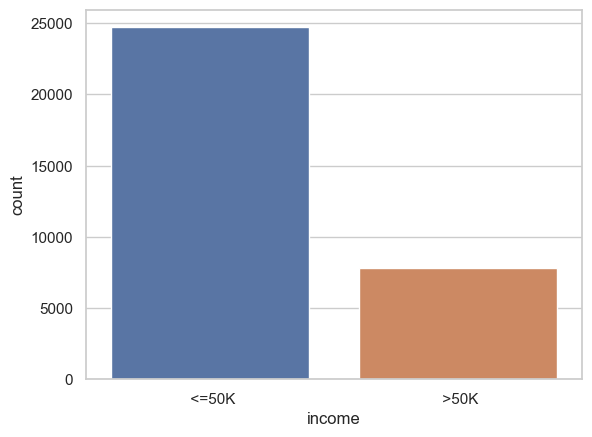

In [299]:
# Si no hacemos esto, las columnas apareceran conforme aparezcan en el dataframe
df_adult_data_decoded = encoder.inverse_transform(df_adult_data)
orden = df_adult_data_decoded.income.value_counts().index

sns.countplot(data=df_adult_data_decoded, x='income', order = orden)
plt.show()

In [300]:
df_adult_data_decoded.income.value_counts()

income
 <=50K    24720
 >50K      7841
Name: count, dtype: int64

Nuestros datos están desbalanceados.
* El modelo aprenderá a clasificar mejor a Benevolentes que Malevolentes
* Esto afectará fuertemente el desempeño de nuestra regresión logística

Hay dos maneras de resolver:
* Reducir todos los dataset a la cantidad de datos de la clase mínima (Malevolente) (Tiene la contra de que perdemos información)
* Empezar a crear ejemplos con la misma desviación estándar/varianza/parámetros o características de cada clase para subir todas las barras a la misma altura, problema: creamos ejemplos que necesariamente no son ciertos

Como tenemos 7,841 observaciones de >50k, vamos a reducir las observaciones <=50k a 7,841 (undersampling)

In [301]:
undersample = RandomUnderSampler(random_state=2024)
X = df_adult_data.drop('income',axis=1)
y = df_adult_data.income
X_under , y_under = undersample.fit_resample(X,y) 

df_adult_data_under = pd.concat([X_under,y_under], axis=1)

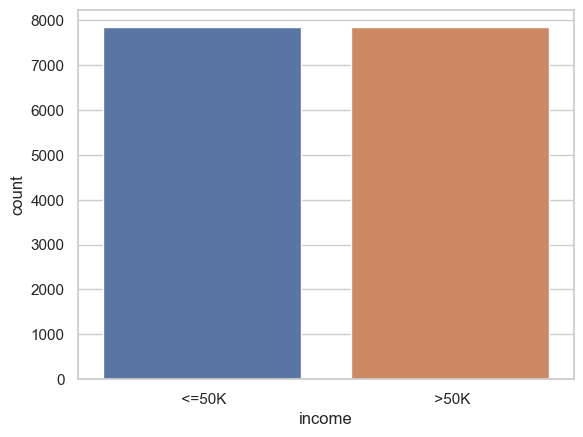

In [302]:
#esta parte solo es para graficar, luego no tendrá utildiad
df_adult_data_under_decoded = encoder.inverse_transform(df_adult_data_under)

X_under_decoded = df_adult_data_under_decoded.drop('income',axis=1)
y_under_decoded = df_adult_data_under_decoded.income


sns.countplot(x=y_under_decoded, order = orden)
plt.show()

## Análisis exploratorio de datos

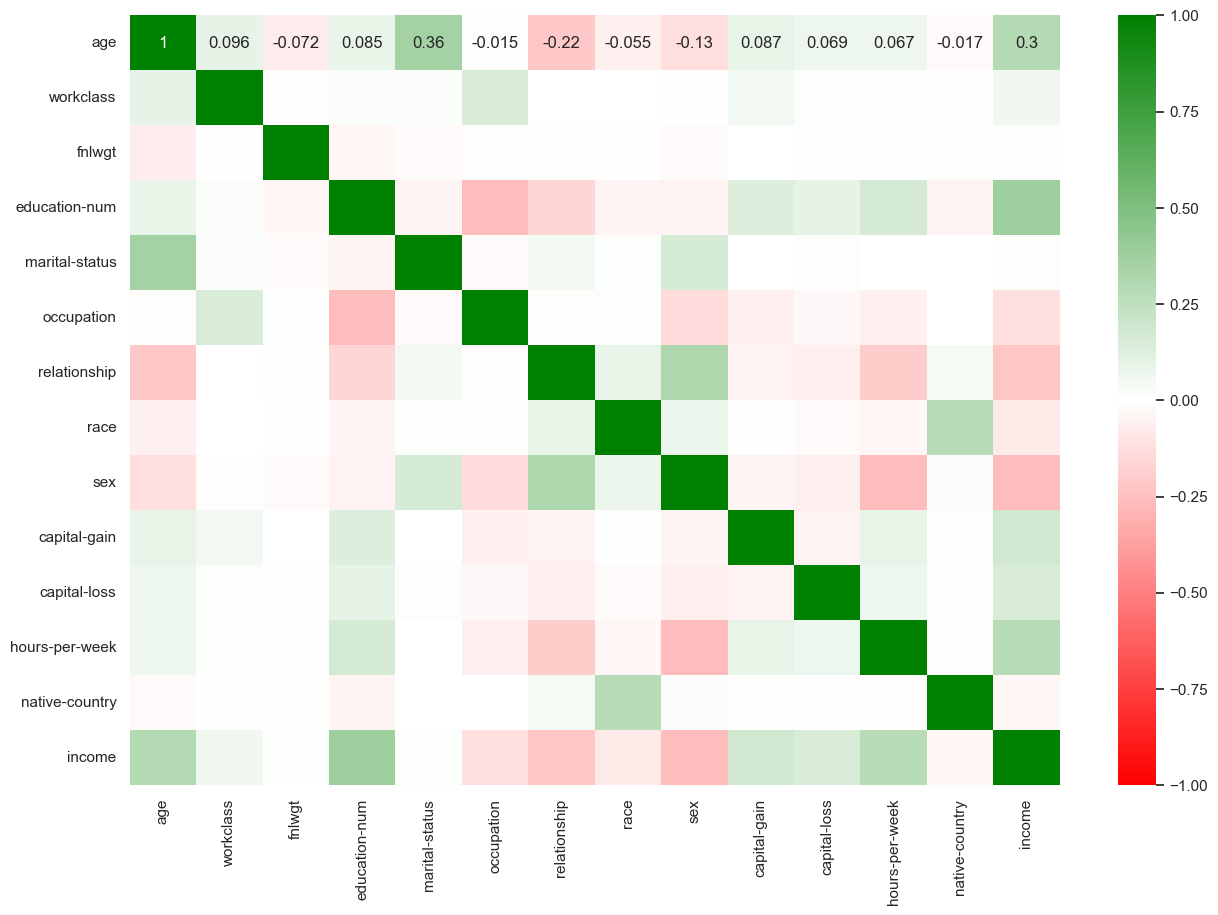

In [303]:
plt.figure(figsize=(15,10))
sns.heatmap(df_adult_data_under.corr(), cmap=cmap,annot=True, vmin = -1, vmax=1)
plt.show()

Se observa my poca correlación entre las variables, esto es positivo porque eliminamos el problema de la multicolinealidad

## Visualizar datos

In [304]:
#sns.pairplot(df_adult_data, hue='income')

Son muchas variables, pero a grueso modo se puede apreciar que hay una marcada diferencia entre las variables income >50k y <=50k

Se procede con el modelo

## Split y escalamiento de datos

No es necesario separar en train y test, porque df_adult_data es el dataset de entrenamiento y df_adult_test es el dataset de prueba

In [305]:
train_weights = df_adult_data_under['fnlwgt'] #guardamos los pesos de cada muestra en el censo
X_train = df_adult_data_under.drop(columns=['fnlwgt','income'])
#X_train = df_adult_data_under.drop(columns=['income'])
y_train = df_adult_data_under['income']

X_test = df_adult_test.drop(columns=['fnlwgt','income'])
#X_test = df_adult_test.drop(columns=['income'])
y_test = df_adult_test['income']


st_x = StandardScaler()
X_train_st = st_x.fit_transform(X_train) #fitea el scaler con los datos de Train
X_test_st = st_x.transform(X_test) #transforma los datos de test con el scaler fiteado con los datos de train

## Modelo binomial

In [306]:
def logistic_model(C_,solver_ , multiclass_):
    logistic_regression_model = LogisticRegression(random_state=42, solver= solver_, multi_class= multiclass_, n_jobs=-1, C=C_ )
    #n_jobs=-1 para que use todos los procesadores

    return logistic_regression_model

In [307]:
multiclass = ['ovr','multinomial'] #ovr (one over rest) es para que funcione con dos clases, multinomial para más de dos
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'] #todos los solvers que funcionan con multinomial
scores = []
params=[]
for i in multiclass:
    for j in solver_list:
        try:  #try porque no todos los solvers funcionan con todas las multiclases
            model = logistic_model(1,j,i)
            model.fit(X_train_st, y_train, sample_weight = train_weights)
            predictions = model.predict(X_test_st)
            params.append(i + '-'+ j)
            accuraccy = accuracy_score(y_test,predictions)
            scores.append(accuraccy)
        except:
            None   

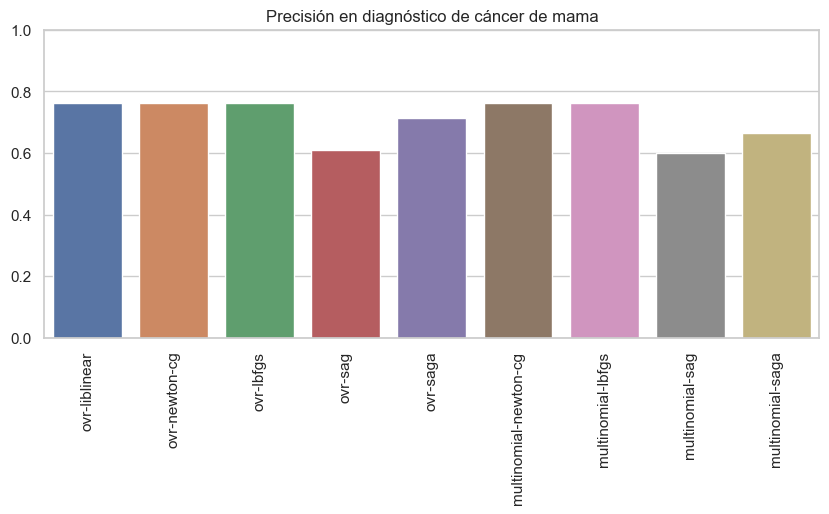

In [308]:
## Evaluación del modelo

fig = plt.figure(figsize=(10,4))
sns.barplot(x=params, y=scores).set_title('Precisión en diagnóstico de cáncer de mama')
#plt.ylim(math.floor(min(scores)*100)/100, max(scores))  # Establecer los límites para el eje Y
plt.ylim(0, 1)  # Establecer los límites para el eje Y

plt.xticks(rotation=90)
plt.show()

In [309]:
pd.DataFrame({'params':params, 'scores':scores}).sort_values(by='scores', ascending=False)

,params,scores
0,ovr-liblinear,0.761931
1,ovr-newton-cg,0.761931
2,ovr-lbfgs,0.761931
5,multinomial-newton-cg,0.761931
6,multinomial-lbfgs,0.761931
4,ovr-saga,0.713900
8,multinomial-saga,0.663718
3,ovr-sag,0.609176
7,multinomial-sag,0.600823


In [310]:
mejor_modelo = params[scores.index(max(scores))]
mejor_modelo

'ovr-liblinear'

In [311]:
model = logistic_model(1,'liblinear','ovr')
model.fit(X_train_st, y_train, sample_weight=train_weights)
predictions = model.predict(X_test_st)

accuraccy_logistic = accuracy_score(y_test,predictions)

print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[9489 2946]
 [ 930 2916]]
0.7619310853141699


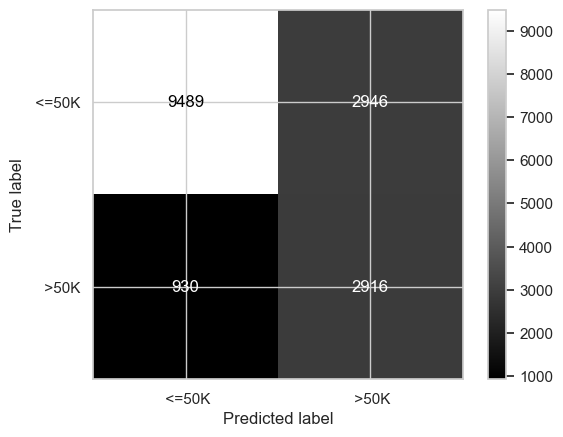

In [312]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=orden) 
#coloque orden porque al inicio lo definimos al hacer nuestro pd.Categorical
disp.plot(cmap='gray')
plt.show()

## Resultados regresión logística
El modelo de regresión logístico tuvo un 76.19% de precisión al momento de determinar si una persona gana más de 50,000 USD al año


# Modelo de Decision Tree


En el arbol de decisión no hay necesidad de hacer undersampling porque el modelo se encarga de balancear los datos

In [313]:
train_weights = df_adult_data['fnlwgt'] #guardamos los pesos de cada muestra en el censo
X_train = df_adult_data.drop(columns=['fnlwgt','income'])
y_train = df_adult_data['income']

X_train_st = st_x.fit_transform(X_train) #fitea el scaler con los datos de Train
X_test_st = st_x.transform(X_test) #transforma los datos de test con el scaler fiteado con los datos de train

X_test = df_adult_test.drop(columns=['fnlwgt','income'])
y_test = df_adult_test['income']

In [314]:
#Creacion del modelo
tree = DecisionTreeClassifier(max_depth=2, random_state = 0)

In [315]:
#Entrenamiento
tree.fit(X_train_st, y_train, sample_weight=train_weights)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [316]:
#Calculo de las predicciones en Train y Test
y_train_pred_tree = tree.predict(X_train_st)
y_test_pred_tree = tree.predict(X_test_st)

## Resultado arbol de decisión

In [317]:
#Calculo de metricas 
from sklearn.metrics import accuracy_score

#Calculo el accuracy en Train
train_accuracy_tree = accuracy_score(y_train, y_train_pred_tree)

#Calculo el accuracy en Test
test_accuracy_tree = accuracy_score(y_test, y_test_pred_tree)

print('El accuracy en train es:', train_accuracy_tree)
print('El accuracy en test es:', test_accuracy_tree)

accuraccy_tree = accuracy_score(y_test,y_test_pred_tree)

El accuracy en train es: 0.8026166272534627
El accuracy en test es: 0.8049259873472145


Estos son buenos resultados, como el accuaracy es alto y similar en ambos casos no hay problema de overfitting

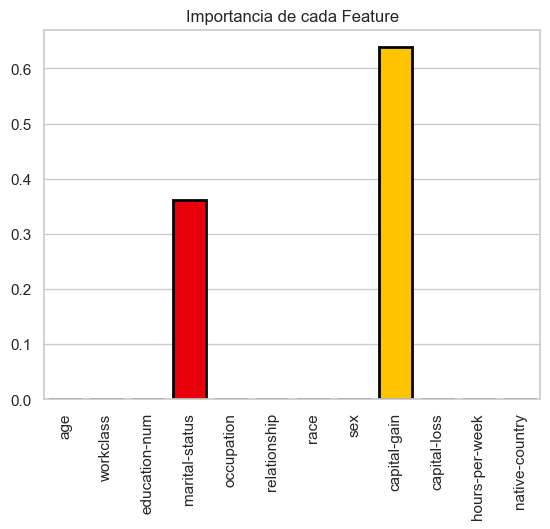

In [318]:
#Verificamos el feature importances

importances = tree.feature_importances_
columns = X_train.columns
sns.barplot(x=columns, y=importances, palette = 'bright', saturation = 2.0, edgecolor ='black', linewidth = 2)
plt.xticks(rotation=90)
plt.title('Importancia de cada Feature')
plt.show()

# Modelo de Random Forest

In [319]:
rf = RandomForestClassifier(n_estimators = 2, random_state = 2024)
rf.fit(X_train_st, y_train, sample_weight=train_weights)

RandomForestClassifier(n_estimators=2, random_state=2024)

In [320]:
#Calculo de las predicciones en Train y Test
y_train_pred_rf = rf.predict(X_train_st)
y_test_pred_rf = rf.predict(X_test_st)

## Resultados Random Forest

In [321]:
#Calculo el accuracy en Train
train_accuracy_rf =accuracy_score(y_train, y_train_pred_rf)

#Calculo el accuracy en Test
test_accuracy_rf =accuracy_score(y_test, y_test_pred_rf)

print('El accuracy en train es:', train_accuracy_rf)
print('El accuracy en test es:', test_accuracy_rf)

accuraccy_rf = accuracy_score(y_test,y_test_pred_rf)
#Importante: podriamos reducir el numero de estimadores para disminuir el sobreajuste del modelo.

El accuracy en train es: 0.9239581093946746
El accuracy en test es: 0.832626988514219


Aparenta haber un ligero overfitting, pero no es tan grave ya que el accuaracy es más alto que el de los otros modelos

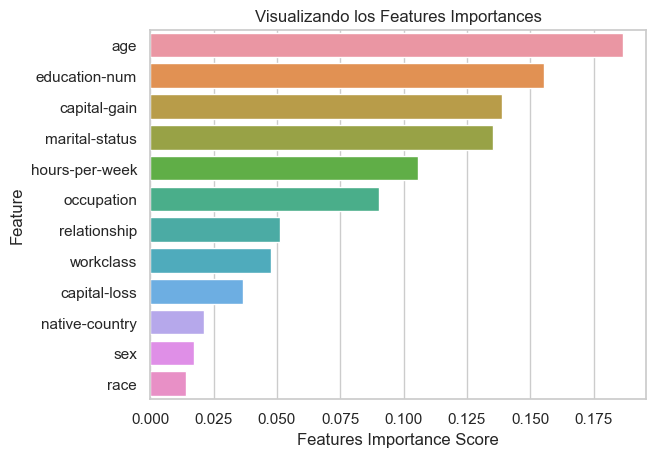

In [341]:
# Visualizacion de las feature importantes
features_scores = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending=False)
features_scores

sns.barplot(x=features_scores , y = features_scores.index)
plt.xlabel('Features Importance Score')
plt.ylabel('Feature')
plt.title("Visualizando los Features Importances")
plt.show()

In [323]:
# Matriz de confusion del RF
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_test_pred_rf)

print('Matriz de Confusion\n\n', cm)

Matriz de Confusion

 [[11641   794]
 [ 1931  1915]]


In [324]:
#RF
from sklearn.metrics import classification_report

print(classification_report(y_test,y_test_pred_rf))

              precision    recall  f1-score   support

           1       0.86      0.94      0.90     12435
           2       0.71      0.50      0.58      3846

    accuracy                           0.83     16281
   macro avg       0.78      0.72      0.74     16281
weighted avg       0.82      0.83      0.82     16281



# Conclusiones


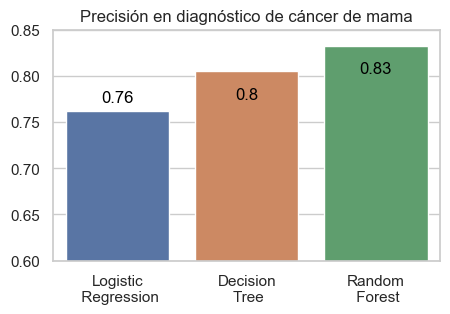

In [340]:
accuraccys = [accuraccy_logistic, accuraccy_tree, accuraccy_rf]
models = ['Logistic\n Regression', 'Decision\n Tree', 'Random\n Forest']
plt.figure(figsize=(5, 3))
barplot = sns.barplot(x=models, y=accuraccys)
barplot.set_title('Precisión en diagnóstico de cáncer de mama')
plt.ylim(0.6, 0.85)  # Establecer los límites para el eje Y

# Ajustar la posición de las etiquetas
for i, v in enumerate(accuraccys):
    offset = 0.01 if v < 0.8 else -0.03  # Ajusta este valor según sea necesario
    plt.text(i, v + offset, str(round(v, 2)), fontsize=12, color='black', ha='center')

plt.xticks(rotation=0)
plt.show()

Los modelos obtuvieron los siguientes resultados al predecir si una persona gana más de 50,000 USD al año:
* El modelo de Random Forest es el que mejor resultados obtuvo en el test de accuracy del test con un 83% de precisión
* El modelo de árbol de decisión tuvo un 80% de precisión
* El modelo de regresión logística tuvo un 76% de precisión
